### Imports

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import numpy as np
from matplotlib import cm
import re
from sklearn import preprocessing, tree, ensemble, linear_model, metrics, model_selection, svm
import xgboost

In [2]:
spray = pd.read_csv('assets/spray.csv')
weather = pd.read_csv('assets/weather.csv')
test = pd.read_csv('assets/west-nile-test.csv')
train = pd.read_csv('assets/west-nile-train.csv')

In [3]:
#dates should be in date-time format for easy wrangling
for i in [spray, weather, test, train]:
    i.Date = pd.to_datetime(i.Date, format='%Y-%m-%d')

### Weather Data - cleaning and wrangling

In [4]:
#many variables are currently objects because they have things like "M" for missing. Must convert.
to_numericize = ['Tavg', 'Depart', 'DewPoint', 'WetBulb', 'Heat', 'Cool', 'PrecipTotal',
                 'StnPressure', 'SeaLevel', 'ResultSpeed', 'ResultDir', 'AvgSpeed']
for col in to_numericize:
    weather[col] = pd.to_numeric(weather[col], errors='coerce')

In [5]:
#for sunrise times and sunset times to be interpreted properly, converting to hours
def twentyfour_hour_to_float(HHMM):
    if HHMM == '-':
        return np.NaN
    else:
        hour = float(HHMM[:2])
        minute = float(HHMM[2:])
        return hour + minute/60
weather.Sunrise = weather.Sunrise.apply(twentyfour_hour_to_float)
weather.Sunset = weather.Sunset.apply(twentyfour_hour_to_float)

#calculate hours in day
weather['hours_in_day'] = weather.Sunset - weather.Sunrise

In [6]:
#Depth, Water1, and SnowFall are all useless variables (all or almost all Nan).
weather.drop(['Depth', 'Water1', 'SnowFall'], axis=1, inplace=True)

In [7]:
#functions to combine data from Station 1 and Station 2, where applicable
def avg_wind_direction(S1, S2):
    if S1 == np.NaN:
        avg = float(S2)
    elif S2 == np.NaN:
        avg = float(S1)
    elif np.abs(S1-S2) > 18:
        if S1<S2:
            S1+=36
        else:
            S2+=36
        avg = (S1+S2)/2.0
    else:
        avg = (S1+S2)/2.0
    if avg >=36:
        avg-=36
    return avg
def combine_conditions(S1, S2):
    if S1 == " " and S2 == " ":
        return ""
    elif S1 == " " and S2 != " ":
        return S2
    elif S1 != " " and S2 == " ":
        return S1
    else:
        S1_list = S1.split(" ")
        S2_list = S2.split(" ")
        return list(set(S1_list + S2_list))
def avg_col(S1, S2):
    if S1 == np.NaN:
        avg = float(S2)
    elif S2 == np.NaN:
        avg = float(S1)
    else: 
        avg=(S1+S2)/2.0
    return avg

In [8]:
combined_weather = pd.DataFrame()

s1 = weather[weather.Station==1]
s2 = weather[weather.Station==1]

#columns that only have data for Station 1 or the data are the same.
for col in ['Date', 'Depart', 'Sunrise', 'Sunset', 'hours_in_day']:
    combined_weather[col] = s1[col].values

#application of averaging function
for col in ['Tmax', 'Tmin', 'Tavg', 'DewPoint', 'WetBulb', 'Heat', 'Cool', 'StnPressure', 'SeaLevel', 'ResultSpeed', 'AvgSpeed']:
    combined_weather[col] = [avg_col(a, b) for a, b in zip(s1[col].values, s2[col].values)]

#application of unique functions
combined_weather['ResultDir'] = [avg_wind_direction(a, b) for a, b in zip(s1.ResultDir.values, s2.ResultDir.values)]
combined_weather['CodeSum'] = [combine_conditions(a, b) for a, b in zip(s1.CodeSum.values, s2.CodeSum.values)]

#PrecipTotal for each station is too different -- keeping both
combined_weather['PrecipTotal_station1'] = weather.PrecipTotal[weather.Station==1].values
combined_weather['PrecipTotal_station2'] = weather.PrecipTotal[weather.Station==2].values

In [9]:
#Unable to accurately impute for PrecipTotals and too much missing, so starting by dropping those columns
combined_weather.drop(['PrecipTotal_station1', 'PrecipTotal_station2'], axis=1, inplace=True)

In [10]:
#impute missing data for.

#WetBulb
X = combined_weather.dropna().drop(['Date', 'WetBulb', 'CodeSum'], axis=1)
y = combined_weather.dropna()['WetBulb']

dt_WetBulb = ensemble.RandomForestRegressor(n_estimators=100)
dt_WetBulb.fit(X, y)

subset = combined_weather.columns.drop('WetBulb')
predicted_WetBulb = dt_WetBulb.predict(combined_weather.dropna(subset=subset).drop(['Date', 'WetBulb', 'CodeSum'], axis=1)[combined_weather.WetBulb.isnull()])

combined_weather.WetBulb[combined_weather.WetBulb.isnull()] = predicted_WetBulb

#StnPressure
X = combined_weather.dropna().drop(['Date', 'StnPressure', 'CodeSum'], axis=1)
y = combined_weather.dropna(subset=subset)['StnPressure']

xb_StnPressure = xgboost.XGBRegressor()
xb_StnPressure.fit(X, y)

predicted_StnPressure = xb_StnPressure.predict(combined_weather.drop(['Date', 'StnPressure', 'CodeSum'], axis=1)[combined_weather.StnPressure.isnull()])

combined_weather.StnPressure[combined_weather.StnPressure.isnull()] = predicted_StnPressure

/anaconda/envs/py27/lib/python2.7/site-packages/ipykernel/__main__.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/anaconda/envs/py27/lib/python2.7/site-packages/ipykernel/__main__.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/anaconda/envs/py27/lib/python2.7/site-packages/ipykernel/__main__.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


### Train/Test Data - cleaning and wrangling

In [11]:
#pull out zip codes from address
def find_zip(address):
    if re.search('(?<=IL )[0-9]*', address):
        return re.search('(?<=IL )[0-9]*', address).group(0)
train['zip_code'] = train.Address.apply(find_zip)

In [12]:
# Address, Street, and AddressNumberAndStreet give essentially the same information as Trap, so they can be deleted
train.drop(['Address', 'Street', 'AddressNumberAndStreet'], axis=1, inplace=True)

In [13]:
#impute missing zips
X = train.dropna()[['Latitude', 'Longitude']]
y = train.dropna()['zip_code']

dtree_forzip = tree.DecisionTreeClassifier()
dtree_forzip.fit(X, y)
predicted_zip = dtree_forzip.predict(train[['Latitude', 'Longitude']][train.zip_code.isnull()])

train.zip_code[train.zip_code.isnull()] = predicted_zip

/anaconda/envs/py27/lib/python2.7/site-packages/ipykernel/__main__.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [14]:
# create columns for day of year, month, day of week:
train['day_of_year'] = train.Date.dt.dayofyear
train['month'] = train.Date.dt.month
train['day_of week'] = train.Date.dt.dayofweek

In [15]:
#repeat all with test data
test['zip_code'] = test.Address.apply(find_zip)
test.drop(['Address', 'Street', 'AddressNumberAndStreet'], axis=1, inplace=True)

predicted_zip = dtree_forzip.predict(test[['Latitude', 'Longitude']][test.zip_code.isnull()])

test.zip_code[test.zip_code.isnull()] = predicted_zip
test['day_of_year'] = test.Date.dt.dayofyear
test['month'] = test.Date.dt.month
test['day_of week'] = test.Date.dt.dayofweek

/anaconda/envs/py27/lib/python2.7/site-packages/ipykernel/__main__.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


### Merge

In [16]:
train_w = pd.merge(train, combined_weather, how='left', on='Date')
test_w = pd.merge(test, combined_weather, how='left', on='Date')

### Preprocessing

In [49]:
le_trap = preprocessing.LabelEncoder()
train_w['Trap_num'] = le_trap.fit_transform(train_w.Trap)

le_species = preprocessing.LabelEncoder()
train_w['Species_num'] = le_species.fit_transform(train_w.Species)

le_zip = preprocessing.LabelEncoder()
train_w['zip_code_num'] = le_zip.fit_transform(train_w.zip_code)

In [50]:
mlb = preprocessing.MultiLabelBinarizer()
mlb_mat = mlb.fit_transform(train_w.CodeSum)
mlb_df = pd.DataFrame(mlb_mat, columns=mlb.classes_)

train_w = pd.concat([train_w, mlb_df], axis=1)

## Model Selection

In [390]:
X = train_w.drop('Date Trap Species CodeSum NumMosquitos WnvPresent zip_code'.split(' '), axis=1)
y = train_w.WnvPresent

In [391]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=.3)

In [392]:
#Decision Tree
dtree = tree.DecisionTreeClassifier()
dtree.fit(X_train, y_train)
predict = dtree.predict_proba(X_test)
metrics.roc_auc_score(y_test, predict[:,1])

0.65679402402859655

In [248]:
#Random Forrest
clf = ensemble.RandomForestClassifier(n_jobs=-1, n_estimators=100)
clf.fit(X_train, y_train)
predict = clf.predict_proba(X_test)
metrics.roc_auc_score(y_test, predict[:,1])

0.75893954264011243

In [249]:
#AdaBoost
ada = ensemble.AdaBoostClassifier(n_estimators=100)
ada.fit(X_train, y_train)

predict = ada.predict_proba(X_test)
metrics.roc_auc_score(y_test, predict[:,1])

0.81927123228648036

In [250]:
#XGBoost
xgb = xgboost.XGBClassifier(n_estimators=100)
xgb.fit(X_train, y_train)

predict = xgb.predict_proba(X_test)
metrics.roc_auc_score(y_test, predict[:,1])

0.82021874601046862

In [251]:
#Cross-validated scores
cv = model_selection.StratifiedKFold(shuffle=True, n_splits=5)
for model, name in zip([clf, ada, xgb], ['clf', 'ada', 'xgb']):
    score = model_selection.cross_val_score(model, X, y, cv=cv, scoring='roc_auc')
    print name, score.mean(), '+/-', score.std()

clf 0.785309938951 +/- 0.0196699459098
ada 0.836095311786 +/- 0.00762405182419
xgb 0.843562238098 +/- 0.0131822055859


In [393]:
#Grid-Search to find best parameters
cv = model_selection.StratifiedKFold(shuffle=True, n_splits=5)
xg_best = model_selection.GridSearchCV(xgboost.XGBClassifier(), param_grid={
        'max_depth':[3,4,5,6, 7],
        'learning_rate':[.04, .06, .08, .1, .12, .14, .16],
    },scoring='roc_auc', cv=cv)
xg_best.fit(X, y).best_params_

# cv = model_selection.StratifiedKFold(shuffle=True, n_splits=5)
xg_best = xgboost.XGBRegressor(learning_rate=0.14, max_depth=3)
score = model_selection.cross_val_score(xg_best, X, y, cv=cv, scoring='roc_auc')
print 'score:',score.mean(),"+/-",score.std()

score: 0.8345379227 +/- 0.0135545642098


Didn't perform any better, so we will keep with the simple model. 

In [256]:
cv = model_selection.StratifiedKFold(shuffle=True, n_splits=5)
predict = model_selection.cross_val_predict(xgboost.XGBClassifier(), X, y, cv=cv, method='predict_proba')
predictions = model_selection.cross_val_predict(xgboost.XGBClassifier(), X, y, cv=cv)
metrics.roc_auc_score(y, predict[:,1])

0.84282893711356266

AUC: 0.840722817105


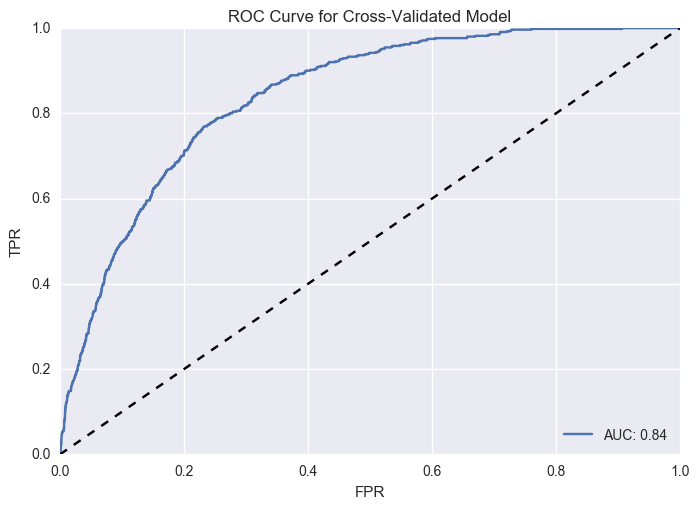

In [299]:
predict = model_selection.cross_val_predict(xgboost.XGBClassifier(), X, y, cv=cv, method='predict_proba')
y_score = predict[:,1]
fpr, tpr, thresholds = metrics.roc_curve(y, y_score)
print 'AUC:', metrics.auc(fpr, tpr)

plt.plot(fpr, tpr, label='AUC: {:.2}'.format(metrics.auc(fpr, tpr)))
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC Curve for Cross-Validated Model')
plt.plot([0, 1], [0, 1], 'k--')
plt.legend(loc='lower right')

In [261]:
print metrics.classification_report(y, predictions)

             precision    recall  f1-score   support

          0       0.95      1.00      0.97      9955
          1       0.50      0.00      0.00       551

avg / total       0.92      0.95      0.92     10506



In [282]:
#Playing with thresholds
predict_p4 = [1 if p < .6 else 0 for p in y_score]
predict_p3 = [1 if p < .7 else 0 for p in y_score]
predict_p2 = [1 if p < .8 else 0 for p in y_score]
predict_p1 = [1 if p < .9 else 0 for p in y_score]

In [283]:
print metrics.classification_report(y, predict_p4)

             precision    recall  f1-score   support

          0       0.00      0.00      0.00      9955
          1       0.05      1.00      0.10       551

avg / total       0.00      0.05      0.01     10506



In [284]:
print metrics.classification_report(y, predict_p3)

             precision    recall  f1-score   support

          0       0.00      0.00      0.00      9955
          1       0.05      1.00      0.10       551

avg / total       0.00      0.05      0.01     10506



In [285]:
print metrics.classification_report(y, predict_p2)

             precision    recall  f1-score   support

          0       0.00      0.00      0.00      9955
          1       0.05      1.00      0.10       551

avg / total       0.00      0.05      0.01     10506



In [286]:
print metrics.classification_report(y, predict_p1)

             precision    recall  f1-score   support

          0       0.00      0.00      0.00      9955
          1       0.05      1.00      0.10       551

avg / total       0.00      0.05      0.01     10506



In [273]:
metrics.confusion_matrix(y, predict_p1)

array([[8386, 1569],
       [ 204,  347]])

In [387]:
#Testing various very-low thresholds
predict = model_selection.cross_val_predict(xgboost.XGBClassifier(seed=1), X, y, cv=cv, method='predict_proba')[:,1]
PREDICTIONS = [1 if p>.06 else 0 for p in predict]
metrics.recall_score(y, PREDICTIONS)
print metrics.classification_report(y, PREDICTIONS)

             precision    recall  f1-score   support

          0       0.99      0.74      0.84      9955
          1       0.14      0.80      0.24       551

avg / total       0.94      0.74      0.81     10506



In [388]:
metrics.confusion_matrix(y, PREDICTIONS)

array([[7358, 2597],
       [ 112,  439]])

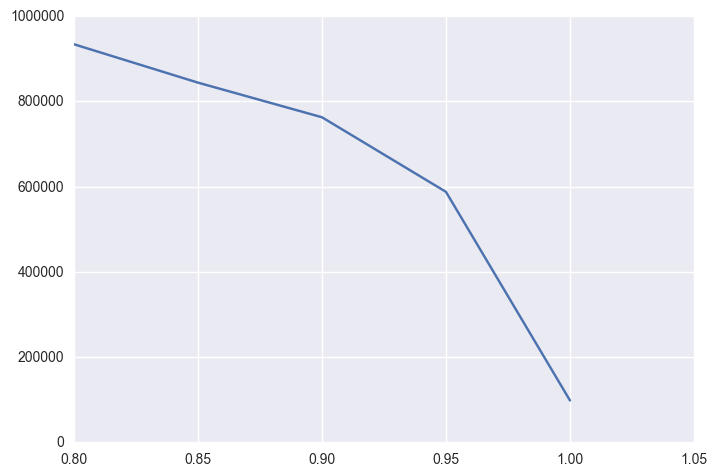

In [389]:
#Graphing savings
recall = [.8, .85, .9, .95, 1]
savings = [933750, 843750, 762500, 587500, 98125]
plt.plot(recall, savings)

# STOP HERE

### Dummie Variables Instead

In [297]:
len(y)*.03

315.18

In [62]:
train_w2 = pd.get_dummies(train_w.drop('CodeSum', axis=1))

In [93]:
X = train_w2.drop('Date NumMosquitos WnvPresent Trap_num Species_num zip_code_num'.split(' '), axis=1)
y = train_w2.WnvPresent

In [64]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=.3)

In [65]:
clf = ensemble.RandomForestClassifier(n_jobs=-1, n_estimators=100)
clf.fit(X_train, y_train)
predict = clf.predict_proba(X_test)
metrics.roc_auc_score(y_test, predict[:,1])

0.79510286395575958

In [66]:
ada = ensemble.AdaBoostClassifier(n_estimators=100)
ada.fit(X_train, y_train)

predict = ada.predict_proba(X_test)
metrics.roc_auc_score(y_test, predict[:,1])

0.83578338110820805

In [67]:
xgb = xgboost.XGBClassifier(n_estimators=100)
xgb.fit(X_train, y_train)

predict = xgb.predict_proba(X_test)
metrics.roc_auc_score(y_test, predict[:,1])

0.85126053795354417

In [68]:
cv = model_selection.StratifiedKFold(shuffle=True, n_splits=5)
for model, name in zip([clf, ada, xgb], ['clf', 'ada', 'xgb']):
    score = model_selection.cross_val_score(model, X, y, cv=cv, scoring='roc_auc')
    print name, score.mean(), '+/-', score.std()

clf 0.779155845037 +/- 0.0156773036024
ada 0.829724513793 +/- 0.0235690080761
xgb 0.843190668409 +/- 0.0142475027905


In [69]:
cv = model_selection.StratifiedKFold(shuffle=True, n_splits=5)
xg_best = model_selection.GridSearchCV(xgboost.XGBClassifier(), param_grid={
        'max_depth':[3,4,5,6, 7],
        'learning_rate':[.04, .06, .08, .1, .12, .14, .16],
    },scoring='roc_auc', cv=cv)
xg_best.fit(X, y).best_params_

{'learning_rate': 0.14, 'max_depth': 5}

In [70]:
# cv = model_selection.StratifiedKFold(shuffle=True, n_splits=5)
xg_best = xgboost.XGBRegressor(learning_rate=0.14, max_depth=4)
score = model_selection.cross_val_score(xg_best, X, y, cv=cv, scoring='roc_auc')
print 'score:',score.mean(),"+/-",score.std()

score: 0.823556520312 +/- 0.0222770753527


In [71]:
cv = model_selection.StratifiedKFold(shuffle=True, n_splits=5)
predict = model_selection.cross_val_predict(xgboost.XGBClassifier(), X, y, cv=cv, method='predict_proba')
metrics.roc_auc_score(y, predict[:,1])

0.83611414705557952

In [72]:
svc = svm.SVC(probability=True)
svc.fit(X_train, y_train)
predict = svc.predict_proba(X_test)
metrics.roc_auc_score(y_test, predict[:,1])

0.70555668298622565

In [73]:
log_reg = linear_model.LogisticRegression()
log_reg.fit(X_train, y_train)
predict = log_reg.predict_proba(X_test)
metrics.roc_auc_score(y_test, predict[:,1])

0.82496638847314885

In [74]:
predict = model_selection.cross_val_predict(log_reg, X, y, cv=cv, method='predict_proba')
metrics.roc_auc_score(y, predict[:,1])

0.81024920672973932

In [76]:
# pd.DataFrame(xgb.feature_importances_, X.columns, columns=['Feature Importance']).sort_values("Feature Importance", ascending=False).to_csv('feature_importances.csv')

In [77]:
# train_w.to_csv('train_with_weather.csv')

### Spray Data

In [17]:
def lat_lon_to_km(lat1, lon1, lat2, lon2):
    vert_dist = (lat2-lat1)*111.2
    hor_dist = (lon2-lon1)*83 #this is an approximation based on some investigation @ movable-type.co.uk/scripts/latlong.html
    dist = (vert_dist**2 + hor_dist**2)**.5
    return dist

In [18]:
traps_loc = train[['Trap', 'Latitude', 'Longitude']].drop_duplicates().reset_index().drop('index', axis=1)

In [19]:
def closest_traps(spray_date, mask=spray.Latitude>0):
    this_spray = spray[spray.Date==spray_date]
    this_spray = this_spray[mask]
    distances = {}
    for i, (lat1, lon1) in enumerate(zip(traps_loc.Latitude, traps_loc.Longitude)):
        trap = traps_loc.Trap.iloc[i]
        total_dist = 0
        for lat2, lon2 in zip(this_spray.Latitude.values, this_spray.Longitude.values):
            total_dist += lat_lon_to_km(lat1, lon1, lat2, lon2)
            avg_dist = total_dist/len(this_spray)
        distances[trap] = avg_dist
    return pd.DataFrame(distances, index=['avg_dist']).transpose().sort_values('avg_dist')

In [20]:
closest_traps('2011-08-29T00:00:00.000000000').head()

/anaconda/envs/py27/lib/python2.7/site-packages/ipykernel/__main__.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  app.launch_new_instance()


,avg_dist
T016,48.371425
T009,48.401259
T233,48.709550
T900,49.397297
T008,50.090672


In [21]:
closest_traps('2011-09-07T00:00:00.000000000').head(10).index.values

/anaconda/envs/py27/lib/python2.7/site-packages/ipykernel/__main__.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  app.launch_new_instance()


array(['T006', 'T223', 'T015', 'T143', 'T014', 'T233', 'T236', 'T016',
       'T002', 'T007'], dtype=object)

In [22]:
train_w[['NumMosquitos', 'WnvPresent', 'Trap', 'Date']][(train_w.Date.dt.year==2011)][(train_w.Trap == 'T006')|(train_w.Trap == 'T223')|(train_w.Trap == 'T015')|(train_w.Trap == 'T143')|(train_w.Trap == 'T014')|(train_w.Trap == 'T233')|(train_w.Trap == 'T236')].groupby(['Trap', 'Date']).agg('sum')

/anaconda/envs/py27/lib/python2.7/site-packages/ipykernel/__main__.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if __name__ == '__main__':


NumMosquitos  WnvPresent
Trap Date                                
T223 2011-06-10             2           0
     2011-06-17            33           0
     2011-07-11            63           0
     2011-07-15           128           0
     2011-07-25           270           0
     2011-07-29            94           1
     2011-08-05           120           0
     2011-08-12             7           1
     2011-08-26             5           1
     2011-09-01            16           1
     2011-09-12            10           0
     2011-09-16            16           0
     2011-09-23            26           1
     2011-09-30             7           0
T233 2011-08-12             9           0
     2011-08-19             1           0
     2011-08-26             3           0
     2011-09-01            10           0
     2011-09-12            16           0
     2011-09-16            37           0
     2011-09-23            13           0
     2011-09-30             4           0
T236 2011-08-19            10           0
     2011-08-26             3           0
     2011-09-12             2           0
     2011-09-16             2           0

In [23]:
closest_traps('2013-07-25T00:00:00.000000000').head(5)

/anaconda/envs/py27/lib/python2.7/site-packages/ipykernel/__main__.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  app.launch_new_instance()


,avg_dist
T228,1.138627
T218,1.386617
T001,1.399472
T146,1.958543
T019,2.293042


In [24]:
train_w[['NumMosquitos', 'WnvPresent', 'Trap', 'Date']][(train_w.Date.dt.year==2013)][(train_w.Trap == 'T218')|(train_w.Trap == 'T228')|(train_w.Trap == 'T001')|(train_w.Trap == 'T146')|(train_w.Trap == 'T019')].groupby(['Trap', 'Date']).agg('sum')

/anaconda/envs/py27/lib/python2.7/site-packages/ipykernel/__main__.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if __name__ == '__main__':


NumMosquitos  WnvPresent
Trap Date                                
T228 2013-06-07             5           0
     2013-06-14            43           0
     2013-06-21             8           0
     2013-06-27            51           0
     2013-07-08             8           0
     2013-07-12            92           1
     2013-07-19           123           2
     2013-07-25            24           0
     2013-08-01            44           0
     2013-08-08            25           0
     2013-08-15            11           0
     2013-08-22            59           1
     2013-08-29            11           0
     2013-09-06            33           1
     2013-09-12             6           0
     2013-09-26             3           0

In [25]:
closest_traps('2013-07-17T00:00:00.000000000', spray.Latitude>41.9).head(5)

/anaconda/envs/py27/lib/python2.7/site-packages/ipykernel/__main__.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  app.launch_new_instance()


,avg_dist
T008,0.858997
T007,1.346276
T236,1.360987
T143,2.094419
T006,2.691383


In [26]:
train_w[['NumMosquitos', 'WnvPresent', 'Trap', 'Date']][(train_w.Date.dt.year==2013)][(train_w.Trap == 'T236')|(train_w.Trap == 'T007')|(train_w.Trap == 'T008')|(train_w.Trap == 'T143')|(train_w.Trap == 'T006')].groupby(['Trap', 'Date']).agg('sum')

/anaconda/envs/py27/lib/python2.7/site-packages/ipykernel/__main__.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if __name__ == '__main__':


NumMosquitos  WnvPresent
Trap Date                                
T008 2013-06-07             1           0
     2013-06-14            35           0
     2013-06-21             8           0
     2013-06-27             2           0
     2013-07-08            42           0
     2013-07-12            78           2
     2013-07-19           245           1
     2013-07-25           118           0
     2013-08-01           174           0
     2013-08-08           165           0
     2013-08-15            59           0
     2013-08-22           124           0
     2013-08-29            51           1
     2013-09-06            22           0
     2013-09-12            17           0
     2013-09-19            11           0
     2013-09-26            10           0
T236 2013-06-07             6           0
     2013-06-14            22           0
     2013-06-21             4           0
     2013-07-08             9           0
     2013-07-12            39           0
     2013-07-19             2           0
     2013-07-25            13           0
     2013-08-01           101           0
     2013-08-08            43           0
     2013-08-15            20           0
     2013-08-22            48           0
     2013-08-29            17           0
     2013-09-06            17           1
     2013-09-12            15           0
     2013-09-19             2           0

In [27]:
closest_traps('2013-07-17T00:00:00.000000000', spray.Latitude<41.9).head(5)

/anaconda/envs/py27/lib/python2.7/site-packages/ipykernel/__main__.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  app.launch_new_instance()


,avg_dist
T159,1.178209
T089,1.233294
T085,1.315712
T094,1.877762
T094B,2.178629


In [28]:
train_w[['NumMosquitos', 'WnvPresent', 'Trap', 'Date']][(train_w.Date.dt.year==2013)][(train_w.Trap == 'T094B')|(train_w.Trap == 'T094')|(train_w.Trap == 'T159')|(train_w.Trap == 'T089')|(train_w.Trap == 'T085')].groupby(['Trap', 'Date']).agg('sum')

/anaconda/envs/py27/lib/python2.7/site-packages/ipykernel/__main__.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if __name__ == '__main__':


NumMosquitos  WnvPresent
Trap  Date                                
T089  2013-06-07             3           0
      2013-06-14             7           0
      2013-06-21            26           0
      2013-06-28            10           0
      2013-07-08            10           0
      2013-07-12            11           0
      2013-07-19            11           0
      2013-07-25            10           0
      2013-08-01             9           0
      2013-08-08             8           1
      2013-08-15             9           0
      2013-08-22             6           0
      2013-08-29            11           1
      2013-09-06            10           0
      2013-09-12            11           0
      2013-09-19             6           1
      2013-09-26             4           0
T094  2013-06-07             4           0
      2013-06-14            67           0
      2013-06-21           167           0
      2013-06-28            38           1
      2013-07-08            20           0
      2013-07-12            14           0
      2013-07-19            29           0
      2013-07-25            15           0
      2013-08-01             4           1
      2013-08-08            64           0
      2013-08-15             8           1
      2013-08-22             9           0
      2013-08-29             1           0
      2013-09-06            31           0
      2013-09-12            14           0
      2013-09-19            11           0
      2013-09-26            12           0
T094B 2013-07-08             5           0
      2013-07-12            20           0
      2013-07-19            16           0
T159  2013-06-07             4           0
      2013-06-14             4           0
      2013-06-21            15           0
      2013-06-28            13           0
      2013-07-08            18           0
      2013-07-12            71           1
      2013-07-19            80           0
      2013-07-25            70           0
      2013-08-01            25           0
      2013-08-08            53           0
      2013-08-15            44           0
      2013-08-22            49           0
      2013-08-29            72           1
      2013-09-06            68           0
      2013-09-12            29           0
      2013-09-19             3           0
      2013-09-26            27           0

In [29]:
closest_traps('2013-08-08T00:00:00.000000000').head(5)

/anaconda/envs/py27/lib/python2.7/site-packages/ipykernel/__main__.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  app.launch_new_instance()


,avg_dist
T147,1.231007
T050,1.702062
T019,2.257700
T224,2.885266
T033,2.934023


In [30]:
train_w[['NumMosquitos', 'WnvPresent', 'Trap', 'Date']][(train_w.Date.dt.year==2013)][(train_w.Trap == 'T147')|(train_w.Trap == 'T050')|(train_w.Trap == 'T019')|(train_w.Trap == 'T224')|(train_w.Trap == 'T033')].groupby(['Trap', 'Date']).agg('sum')

/anaconda/envs/py27/lib/python2.7/site-packages/ipykernel/__main__.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if __name__ == '__main__':


NumMosquitos  WnvPresent
Trap Date                                
T033 2013-06-07             1           0
     2013-06-21             1           0
     2013-06-27             3           0
     2013-07-08             3           0
     2013-07-12             5           0
     2013-07-19             8           0
     2013-07-25             9           0
     2013-08-01             4           0
     2013-08-08            25           0
     2013-08-15            51           0
     2013-08-22            27           1
     2013-08-29            15           1
     2013-09-06           109           1
     2013-09-12            12           0
     2013-09-19            16           0
     2013-09-26             2           0
T147 2013-06-14             9           0
     2013-06-21             1           0
     2013-06-27             7           0
     2013-07-08             6           0
     2013-07-12            28           0
     2013-07-19             6           0
     2013-07-25             3           0
     2013-08-01            61           3
     2013-08-08             5           0
     2013-08-15             7           0
     2013-08-22             8           0
     2013-08-29            11           0
     2013-09-12            21           1
     2013-09-19             2           0
T224 2013-06-07             3           0
     2013-06-14            14           0
     2013-06-21             4           0
     2013-07-08             5           0
     2013-07-12            23           0
     2013-07-19             5           0
     2013-07-25            11           0
     2013-08-01            29           1
     2013-08-08             5           0
     2013-08-15            30           0
     2013-08-22            28           0
     2013-08-29            13           0
     2013-09-06            13           0
     2013-09-12            30           0
     2013-09-19             9           0
     2013-09-26             3           0

In [31]:
closest_traps('2013-08-15T00:00:00.000000000', spray.Latitude>41.91).head(8)

/anaconda/envs/py27/lib/python2.7/site-packages/ipykernel/__main__.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  app.launch_new_instance()


,avg_dist
T144,1.725384
T013,2.106002
T005,2.151685
T037,2.268334
T002,2.611073
T151,2.734786
T142,2.737773
T017,3.343213


In [32]:
train_w[['NumMosquitos', 'WnvPresent', 'Trap', 'Date']][(train_w.Date.dt.year==2013)][(train_w.Trap == 'T144')|(train_w.Trap == 'T013')|(train_w.Trap == 'T005')|(train_w.Trap == 'T037')|(train_w.Trap == 'T002')|(train_w.Trap == 'T017')|(train_w.Trap == 'T142')|(train_w.Trap == 'T151')].groupby(['Trap', 'Date']).agg('sum')

/anaconda/envs/py27/lib/python2.7/site-packages/ipykernel/__main__.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if __name__ == '__main__':


NumMosquitos  WnvPresent
Trap Date                                
T002 2013-06-07            19           0
     2013-06-14           314           0
     2013-06-21            19           0
     2013-06-27            19           0
     2013-07-08           246           0
     2013-07-12           582           0
     2013-07-19            34           0
     2013-07-25            28           0
     2013-08-01            34           0
     2013-08-08           196           4
     2013-08-15            11           0
     2013-08-22            46           2
     2013-08-29            70           1
     2013-09-06            90           0
     2013-09-12            44           1
     2013-09-19            27           0
     2013-09-26            13           0
T013 2013-06-07             1           0
     2013-06-14             5           0
     2013-06-21            10           0
     2013-06-27            10           0
     2013-07-08             7           0
     2013-07-12            84           0
     2013-07-19            43           1
     2013-07-25            14           0
     2013-08-01            60           1
     2013-08-08           141           2
     2013-08-15            40           1
     2013-08-22            12           0
     2013-08-29           124           0
...                       ...         ...
T017 2013-06-27             2           0
     2013-07-08             2           0
     2013-07-12             7           0
     2013-07-19             6           0
     2013-07-25             9           0
     2013-08-01            12           0
     2013-08-08            16           0
     2013-08-15             7           0
     2013-08-22             9           0
     2013-08-29            11           0
     2013-09-06             9           0
     2013-09-12            13           0
     2013-09-19            10           0
     2013-09-26             2           0
T151 2013-06-07             7           0
     2013-06-14            11           0
     2013-06-21            27           0
     2013-06-27            86           0
     2013-07-08            37           0
     2013-07-12            22           0
     2013-07-19            45           0
     2013-07-25            34           0
     2013-08-01            88           0
     2013-08-08            82           1
     2013-08-15            20           1
     2013-08-22            21           0
     2013-08-29            17           0
     2013-09-06            31           1
     2013-09-19            36           0
     2013-09-26             8           0

[66 rows x 2 columns]

In [33]:
closest_traps('2013-08-15T00:00:00.000000000', spray.Latitude<=41.91).head(5)

/anaconda/envs/py27/lib/python2.7/site-packages/ipykernel/__main__.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  app.launch_new_instance()


,avg_dist
T230,1.061189
T153,1.212686
T154,2.378972
T222,3.199107
T039,3.226038


In [34]:
train_w[['NumMosquitos', 'WnvPresent', 'Trap', 'Date']][(train_w.Date.dt.year==2013)][(train_w.Trap == 'T039')|(train_w.Trap == 'T153')|(train_w.Trap == 'T230')|(train_w.Trap == 'T154')|(train_w.Trap == 'T222')].groupby(['Trap', 'Date']).agg('sum')

/anaconda/envs/py27/lib/python2.7/site-packages/ipykernel/__main__.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if __name__ == '__main__':


NumMosquitos  WnvPresent
Trap Date                                
T039 2013-06-14             8           0
     2013-07-08             2           0
     2013-07-12             4           0
     2013-07-19             7           0
     2013-07-25             4           0
     2013-08-01             4           0
     2013-08-08            25           0
     2013-08-15             2           0
     2013-08-22             9           0
     2013-08-29            19           1
     2013-09-06            28           0
     2013-09-12            14           1
     2013-09-19            30           0
     2013-09-26             8           0
T222 2013-06-14             7           0
     2013-06-27             3           0
     2013-07-08             6           0
     2013-07-12             4           0
     2013-07-19            17           0
     2013-07-25             2           0
     2013-08-01             2           0
     2013-08-08             9           0
     2013-08-15             2           0
     2013-08-22             7           0
     2013-08-29            17           1
     2013-09-06             5           0
     2013-09-12             3           0
     2013-09-19             3           0
     2013-09-26             1           0
T230 2013-06-07             3           0
     2013-06-14            16           0
     2013-06-21             5           0
     2013-06-27            10           0
     2013-07-08            20           0
     2013-07-12            27           0
     2013-07-19            46           1
     2013-07-25            19           0
     2013-08-01            10           0
     2013-08-08            31           3
     2013-08-15            15           1
     2013-08-22             3           0
     2013-08-29             2           0
     2013-09-06             6           0
     2013-09-12           115           0
     2013-09-19            47           0
     2013-09-26            18           0

In [35]:
closest_traps('2013-08-16T00:00:00.000000000').head(5)

/anaconda/envs/py27/lib/python2.7/site-packages/ipykernel/__main__.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  app.launch_new_instance()


,avg_dist
T017,0.660921
T142,0.890517
T014,1.532797
T002,1.836731
T141,1.919161


In [36]:
train_w[['NumMosquitos', 'WnvPresent', 'Trap', 'Date']][(train_w.Date.dt.year==2013)][(train_w.Trap == 'T141')|(train_w.Trap == 'T017')|(train_w.Trap == 'T142')|(train_w.Trap == 'T014')|(train_w.Trap == 'T002')].groupby(['Trap', 'Date']).agg('sum')

/anaconda/envs/py27/lib/python2.7/site-packages/ipykernel/__main__.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if __name__ == '__main__':


NumMosquitos  WnvPresent
Trap Date                                
T002 2013-06-07            19           0
     2013-06-14           314           0
     2013-06-21            19           0
     2013-06-27            19           0
     2013-07-08           246           0
     2013-07-12           582           0
     2013-07-19            34           0
     2013-07-25            28           0
     2013-08-01            34           0
     2013-08-08           196           4
     2013-08-15            11           0
     2013-08-22            46           2
     2013-08-29            70           1
     2013-09-06            90           0
     2013-09-12            44           1
     2013-09-19            27           0
     2013-09-26            13           0
T017 2013-06-14             4           0
     2013-06-21             1           0
     2013-06-27             2           0
     2013-07-08             2           0
     2013-07-12             7           0
     2013-07-19             6           0
     2013-07-25             9           0
     2013-08-01            12           0
     2013-08-08            16           0
     2013-08-15             7           0
     2013-08-22             9           0
     2013-08-29            11           0
     2013-09-06             9           0
     2013-09-12            13           0
     2013-09-19            10           0
     2013-09-26             2           0

In [37]:
closest_traps('2013-08-22T00:00:00.000000000').head(5)

/anaconda/envs/py27/lib/python2.7/site-packages/ipykernel/__main__.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  app.launch_new_instance()


,avg_dist
T047,9.253888
T088,9.258959
T043,9.264830
T034,9.360162
T044,9.381762


In [38]:
train_w[['NumMosquitos', 'WnvPresent', 'Trap', 'Date']][(train_w.Date.dt.year==2013)][(train_w.Trap == 'T044')|(train_w.Trap == 'T047')|(train_w.Trap == 'T088')|(train_w.Trap == 'T043')|(train_w.Trap == 'T034')].groupby(['Trap', 'Date']).agg('sum')

/anaconda/envs/py27/lib/python2.7/site-packages/ipykernel/__main__.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if __name__ == '__main__':


NumMosquitos  WnvPresent
Trap Date                                
T043 2013-06-14             3           0
     2013-06-27             1           0
     2013-07-12             4           0
     2013-07-19             4           0
     2013-07-25             3           0
     2013-08-01             2           0
     2013-08-08            10           0
     2013-08-15            19           0
     2013-08-22             2           0
     2013-08-29             3           0
     2013-09-06             4           0
     2013-09-12             5           0
     2013-09-19             1           0
T047 2013-06-07             2           0
     2013-06-14             1           0
     2013-06-21            11           0
     2013-06-27             3           0
     2013-07-08            24           0
     2013-07-12           112           0
     2013-07-19            56           0
     2013-07-25            16           0
     2013-08-01             5           0
     2013-08-08            10           0
     2013-08-15            51           2
     2013-08-22            13           1
     2013-08-29             8           0
     2013-09-06            32           0
     2013-09-12            36           0
     2013-09-19            34           0
     2013-09-26            11           0

In [39]:
closest_traps('2013-08-29T00:00:00.000000000', spray.Latitude<41.9).head(5)

/anaconda/envs/py27/lib/python2.7/site-packages/ipykernel/__main__.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  app.launch_new_instance()


,avg_dist
T066,1.657849
T156,2.159531
T238,2.637938
T035,2.644215
T067,3.104986


In [40]:
train_w[['NumMosquitos', 'WnvPresent', 'Trap', 'Date']][(train_w.Date.dt.year==2013)][(train_w.Trap == 'T067')|(train_w.Trap == 'T035')|(train_w.Trap == 'T238')|(train_w.Trap == 'T156')|(train_w.Trap == 'T066')].groupby(['Trap', 'Date']).agg('sum')

/anaconda/envs/py27/lib/python2.7/site-packages/ipykernel/__main__.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if __name__ == '__main__':


NumMosquitos  WnvPresent
Trap Date                                
T035 2013-06-07             1           0
     2013-06-14             4           0
     2013-06-21            10           0
     2013-06-28             4           0
     2013-07-08             9           0
     2013-07-12             8           0
     2013-07-19             9           0
     2013-07-25             6           0
     2013-08-01             4           0
     2013-08-08             7           0
     2013-08-15            18           0
     2013-08-22             5           0
     2013-08-29             8           0
     2013-09-06            31           1
     2013-09-12            18           0
     2013-09-19            20           0
     2013-09-26             6           1
T066 2013-06-07             5           0
     2013-06-14            10           0
     2013-06-21            24           0
     2013-06-27             5           0
     2013-07-08             7           0
     2013-07-12            54           0
     2013-07-19            54           0
     2013-07-25            30           0
     2013-08-01            24           0
     2013-08-08           154           1
     2013-08-15            71           1
     2013-08-22            48           2
     2013-08-29            51           0
     2013-09-06            35           0
     2013-09-12           105           1
     2013-09-19            23           0
     2013-09-26             6           0

In [41]:
closest_traps('2013-08-29T00:00:00.000000000', spray.Latitude>41.9).head(5)

/anaconda/envs/py27/lib/python2.7/site-packages/ipykernel/__main__.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  app.launch_new_instance()


,avg_dist
T028,0.947436
T231,1.583165
T149,1.684284
T150,2.411980
T219,2.423614


In [42]:
train_w[['NumMosquitos', 'WnvPresent', 'Trap', 'Date']][(train_w.Date.dt.year==2013)][(train_w.Trap == 'T067')|(train_w.Trap == 'T219')|(train_w.Trap == 'T150')|(train_w.Trap == 'T149')|(train_w.Trap == 'T231')].groupby(['Trap', 'Date']).agg('sum')

/anaconda/envs/py27/lib/python2.7/site-packages/ipykernel/__main__.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if __name__ == '__main__':


NumMosquitos  WnvPresent
Trap Date                                
T231 2013-06-14             2           0
     2013-06-21             5           0
     2013-06-27             2           0
     2013-07-08             1           0
     2013-07-12           150           1
     2013-07-19            67           0
     2013-07-25             3           0
     2013-08-01            44           1
     2013-08-08            42           0
     2013-08-15            20           0
     2013-08-22            80           1
     2013-08-29            50           1
     2013-09-06            22           0
     2013-09-12             4           0
     2013-09-19             9           0
     2013-09-26             5           0

In [43]:
closest_traps('2013-09-05T00:00:00.000000000', spray.Latitude>41.98).head(5)

/anaconda/envs/py27/lib/python2.7/site-packages/ipykernel/__main__.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  app.launch_new_instance()


,avg_dist
T016,1.008007
T233,1.038595
T143,1.753438
T006,2.320621
T008,2.959859


In [44]:
train_w[['NumMosquitos', 'WnvPresent', 'Trap', 'Date']][(train_w.Date.dt.year==2013)][(train_w.Trap == 'T016')|(train_w.Trap == 'T233')|(train_w.Trap == 'T143')|(train_w.Trap == 'T008')|(train_w.Trap == 'T006')].groupby(['Trap', 'Date']).agg('sum')

/anaconda/envs/py27/lib/python2.7/site-packages/ipykernel/__main__.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if __name__ == '__main__':


NumMosquitos  WnvPresent
Trap Date                                
T008 2013-06-07             1           0
     2013-06-14            35           0
     2013-06-21             8           0
     2013-06-27             2           0
     2013-07-08            42           0
     2013-07-12            78           2
     2013-07-19           245           1
     2013-07-25           118           0
     2013-08-01           174           0
     2013-08-08           165           0
     2013-08-15            59           0
     2013-08-22           124           0
     2013-08-29            51           1
     2013-09-06            22           0
     2013-09-12            17           0
     2013-09-19            11           0
     2013-09-26            10           0
T233 2013-06-07             1           0
     2013-06-14            19           0
     2013-06-21             2           0
     2013-06-27             4           0
     2013-07-08             2           0
     2013-07-12            10           0
     2013-07-19            33           0
     2013-07-25            16           0
     2013-08-01            19           0
     2013-08-08           145           1
     2013-08-15            34           0
     2013-08-22            79           1
     2013-08-29           200           3
     2013-09-06            33           2
     2013-09-12            42           0
     2013-09-19            21           0
     2013-09-26             5           0

In [45]:
spray.Date.dt.year.unique()

array([2011, 2013])

In [46]:
spray.Date[spray.Date.dt.year==2011].unique()

array(['2011-08-29T00:00:00.000000000', '2011-09-07T00:00:00.000000000'], dtype='datetime64[ns]')

In [47]:
lat_lon_to_km(42.38946, -88.0879883333, 42.3959833333, -88.0964683333)

1.0107364456920733

In [48]:
spray.Date[spray.Date.dt.year==2013].unique()

array(['2013-07-17T00:00:00.000000000', '2013-07-25T00:00:00.000000000',
       '2013-08-08T00:00:00.000000000', '2013-08-15T00:00:00.000000000',
       '2013-08-16T00:00:00.000000000', '2013-08-22T00:00:00.000000000',
       '2013-08-29T00:00:00.000000000', '2013-09-05T00:00:00.000000000'], dtype='datetime64[ns]')

### Looking at predicting by date and trap, not by species

In [78]:
t = pd.merge(train, combined_weather, how='left', on='Date')

In [79]:
t.head()

,Date,Species,Block,Trap,Latitude,Longitude,AddressAccuracy,NumMosquitos,WnvPresent,zip_code,...,DewPoint,WetBulb,Heat,Cool,StnPressure,SeaLevel,ResultSpeed,AvgSpeed,ResultDir,CodeSum
0,2007-05-29,CULEX PIPIENS/RESTUANS,41,T002,41.954690,-87.800991,9,1,0,60634,...,58.0,65.0,0.0,9.0,29.39,30.11,5.8,6.5,18.0,"[HZ, BR]"
1,2007-05-29,CULEX RESTUANS,41,T002,41.954690,-87.800991,9,1,0,60634,...,58.0,65.0,0.0,9.0,29.39,30.11,5.8,6.5,18.0,"[HZ, BR]"
2,2007-05-29,CULEX RESTUANS,62,T007,41.994991,-87.769279,9,1,0,60646,...,58.0,65.0,0.0,9.0,29.39,30.11,5.8,6.5,18.0,"[HZ, BR]"
3,2007-05-29,CULEX PIPIENS/RESTUANS,79,T015,41.974089,-87.824812,8,1,0,60656,...,58.0,65.0,0.0,9.0,29.39,30.11,5.8,6.5,18.0,"[HZ, BR]"
4,2007-05-29,CULEX RESTUANS,79,T015,41.974089,-87.824812,8,4,0,60656,...,58.0,65.0,0.0,9.0,29.39,30.11,5.8,6.5,18.0,"[HZ, BR]"


In [80]:
train_trap = t[['Date', 'Trap', 'NumMosquitos', 'WnvPresent']].groupby(['Date', 'Trap'], as_index=False).agg(sum)

In [81]:
a = pd.merge(train_trap, t.drop(['NumMosquitos', 'WnvPresent', 'Species'], axis=1), on=['Date', 'Trap'], how='left')

In [82]:
mlb = preprocessing.MultiLabelBinarizer()
mlb_mat = mlb.fit_transform(a.CodeSum)
mlb_df = pd.DataFrame(mlb_mat, columns=mlb.classes_)

train_trap = pd.concat([a.drop('CodeSum', axis=1), mlb_df], axis=1).drop_duplicates()

In [83]:
train_trap['is_wnv_present'] = train_trap.WnvPresent.apply(lambda x: 1 if x>0 else 0)

In [84]:
le_trap2 = preprocessing.LabelEncoder()
train_trap['Trap_num'] = le_trap2.fit_transform(train_trap.Trap)

le_zip2 = preprocessing.LabelEncoder()
train_trap['zip_code_num'] = le_zip2.fit_transform(train_trap.zip_code)

In [85]:
X = train_trap.drop('Date Trap NumMosquitos WnvPresent zip_code is_wnv_present'.split(' '), axis=1)
y = train_trap.is_wnv_present

In [86]:
model_selection.cross_val_score(xgboost.XGBClassifier(), X, y, scoring='roc_auc', cv=cv).mean()

0.85964115556544396

In [88]:
traps_in_1km = {}

for trap, lat, lon in set(zip(train_trap.Trap.values, train_trap.Latitude.values, train_trap.Longitude.values)):
    traps_in_1km[trap] = []
    for traps, lats, lons in set(zip(train_trap.Trap.values, train_trap.Latitude.values, train_trap.Longitude.values)):
        if lat_lon_to_km(lat, lon, lats, lons) <= 1 and traps != trap:
            traps_in_1km[trap].append(traps)   

In [89]:
traps_in_1p5_km = {}

for trap, lat, lon in set(zip(train_trap.Trap.values, train_trap.Latitude.values, train_trap.Longitude.values)):
    traps_in_1p5_km[trap] = []
    for traps, lats, lons in set(zip(train_trap.Trap.values, train_trap.Latitude.values, train_trap.Longitude.values)):
        if lat_lon_to_km(lat, lon, lats, lons) <= 1.5 and traps != trap:
            traps_in_1p5_km[trap].append(traps)

In [90]:
traps_in_2km = {}

for trap, lat, lon in set(zip(train_trap.Trap.values, train_trap.Latitude.values, train_trap.Longitude.values)):
    traps_in_2km[trap] = []
    for traps, lats, lons in set(zip(train_trap.Trap.values, train_trap.Latitude.values, train_trap.Longitude.values)):
        if lat_lon_to_km(lat, lon, lats, lons) <= 2 and traps != trap:
            traps_in_2km[trap].append(traps)

In [114]:
traps_in_2km

{'T001': ['T004', 'T218', 'T228'],
 'T002': ['T144'],
 'T003': ['T141', 'T004', 'T025', 'T017'],
 'T004': ['T001', 'T141', 'T025', 'T003'],
 'T005': ['T142', 'T144'],
 'T006': ['T009', 'T223', 'T143'],
 'T007': ['T008', 'T012', 'T236'],
 'T008': ['T007', 'T236', 'T143'],
 'T009': [],
 'T011': [],
 'T012': ['T027', 'T025', 'T007'],
 'T013': ['T151', 'T144', 'T037'],
 'T014': ['T223', 'T017'],
 'T015': ['T009', 'T223'],
 'T016': ['T233', 'T143'],
 'T017': ['T141', 'T142', 'T003', 'T014'],
 'T018': ['T149', 'T150'],
 'T019': ['T220', 'T147', 'T146'],
 'T025': ['T027', 'T004', 'T012', 'T003'],
 'T027': ['T025', 'T012'],
 'T028': ['T231'],
 'T030': ['T039', 'T033'],
 'T031': [],
 'T033': ['T160', 'T030', 'T050'],
 'T034': ['T043', 'T035'],
 'T035': ['T060', 'T074', 'T034', 'T157'],
 'T036': ['T152', 'T063', 'T040'],
 'T037': ['T013', 'T151'],
 'T039': ['T030'],
 'T040': ['T152', 'T036'],
 'T043': ['T047', 'T088', 'T034'],
 'T044': ['T047', 'T088'],
 'T045': ['T232'],
 'T046': ['T049'],
 'T0

In [ ]:
train.it

In [120]:
big_dict = {}
for trap1 in set(train_trap.Trap):
    big_dict[trap1] = {}
    for date in set(train_trap.Date):
        big_dict[trap1][date] = 0
        for trap2 in traps_in_1km[trap1]:
            for index, row in train_trap[(train_trap.Trap == trap2)&(train_trap.Date < date)&(train_trap.Date >= train_trap.Date - pd.Timedelta('14 days'))].iterrows():
                if row.WnvPresent > 0:
                    big_dict[trap1][date]+=1

{'T001': {Timestamp('2007-05-29 00:00:00'): 0,
  Timestamp('2007-06-05 00:00:00'): 0,
  Timestamp('2007-06-26 00:00:00'): 0,
  Timestamp('2007-06-29 00:00:00'): 0,
  Timestamp('2007-07-02 00:00:00'): 0,
  Timestamp('2007-07-11 00:00:00'): 0,
  Timestamp('2007-07-18 00:00:00'): 0,
  Timestamp('2007-07-19 00:00:00'): 0,
  Timestamp('2007-07-25 00:00:00'): 0,
  Timestamp('2007-07-27 00:00:00'): 0,
  Timestamp('2007-08-01 00:00:00'): 0,
  Timestamp('2007-08-02 00:00:00'): 0,
  Timestamp('2007-08-03 00:00:00'): 0,
  Timestamp('2007-08-07 00:00:00'): 0,
  Timestamp('2007-08-08 00:00:00'): 0,
  Timestamp('2007-08-09 00:00:00'): 0,
  Timestamp('2007-08-15 00:00:00'): 0,
  Timestamp('2007-08-16 00:00:00'): 0,
  Timestamp('2007-08-17 00:00:00'): 0,
  Timestamp('2007-08-21 00:00:00'): 0,
  Timestamp('2007-08-22 00:00:00'): 0,
  Timestamp('2007-08-24 00:00:00'): 0,
  Timestamp('2007-08-28 00:00:00'): 0,
  Timestamp('2007-09-04 00:00:00'): 0,
  Timestamp('2007-09-05 00:00:00'): 0,
  Timestamp('2007

In [128]:
a = pd.DataFrame(big_dict).reset_index().rename_axis({'index':'Date'}, axis=1)

In [203]:
a

,Date,T001,T002,T003,T004,T005,T006,T007,T008,T009,...,T230,T231,T232,T233,T235,T236,T237,T238,T900,T903
0,2007-05-29,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2007-06-05,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2007-06-26,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,2007-06-29,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,2007-07-02,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,2007-07-11,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,2007-07-18,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,2007-07-19,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,2007-07-25,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,2007-07-27,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [143]:
a1 = pd.melt(a, id_vars='Date', value_name='wnv_present_nearby', var_name='Trap')

In [204]:
a1

,Date,Trap,wnv_present_nearby
0,2007-05-29,T001,0
1,2007-06-05,T001,0
2,2007-06-26,T001,0
3,2007-06-29,T001,0
4,2007-07-02,T001,0
5,2007-07-11,T001,0
6,2007-07-18,T001,0
7,2007-07-19,T001,0
8,2007-07-25,T001,0
9,2007-07-27,T001,0


In [145]:
new_train_merged = pd.merge(train_w, a1, how='left', on=['Date', 'Trap'])

In [146]:
new_train_merged

,Date,Species,Block,Trap,Latitude,Longitude,AddressAccuracy,NumMosquitos,WnvPresent,zip_code,...,zip_code_num,BR,DZ,FG,HZ,RA,TS,TSRA,VCTS,wnv_present_nearby
0,2007-05-29,CULEX PIPIENS/RESTUANS,41,T002,41.954690,-87.800991,9,1,0,60634,...,26,1,0,0,1,0,0,0,0,0
1,2007-05-29,CULEX RESTUANS,41,T002,41.954690,-87.800991,9,1,0,60634,...,26,1,0,0,1,0,0,0,0,0
2,2007-05-29,CULEX RESTUANS,62,T007,41.994991,-87.769279,9,1,0,60646,...,36,1,0,0,1,0,0,0,0,0
3,2007-05-29,CULEX PIPIENS/RESTUANS,79,T015,41.974089,-87.824812,8,1,0,60656,...,43,1,0,0,1,0,0,0,0,0
4,2007-05-29,CULEX RESTUANS,79,T015,41.974089,-87.824812,8,4,0,60656,...,43,1,0,0,1,0,0,0,0,0
5,2007-05-29,CULEX RESTUANS,15,T045,41.921600,-87.666455,8,2,0,60614,...,9,1,0,0,1,0,0,0,0,0
6,2007-05-29,CULEX RESTUANS,25,T046,41.891118,-87.654491,8,1,0,60654,...,41,1,0,0,1,0,0,0,0,0
7,2007-05-29,CULEX PIPIENS/RESTUANS,11,T048,41.867108,-87.654224,8,1,0,60608,...,4,1,0,0,1,0,0,0,0,0
8,2007-05-29,CULEX RESTUANS,11,T048,41.867108,-87.654224,8,2,0,60608,...,4,1,0,0,1,0,0,0,0,0
9,2007-05-29,CULEX RESTUANS,11,T049,41.896282,-87.655232,8,1,0,60642,...,33,1,0,0,1,0,0,0,0,0


In [142]:
# for trap, nearby in traps_in_1km.iteritems():
#     for date in set(train_trap.Date.values):
#         for trap in set(train_trap.Trap.values):
#             train_trap[train_trap.Date.dt]

In [168]:
X = new_train_merged.drop('Date Trap Species CodeSum NumMosquitos WnvPresent zip_code wnv_present_nearby'.split(' '), axis=1)
y = new_train_merged.WnvPresent
xgb = xgboost.XGBClassifier(n_estimators=100)
xgb.fit(X_train, y_train)

prediction = xgb.predict(X_test)

In [169]:
new_train_merged2 = X_test.copy()

In [170]:
new_train_merged2['predicted_wnv'] = prediction

In [202]:
list(new_train_merged2.columns)

['Block',
 'Latitude',
 'Longitude',
 'AddressAccuracy',
 'day_of_year',
 'month',
 'day_of week',
 'Depart',
 'Sunrise',
 'Sunset',
 'hours_in_day',
 'Tmax',
 'Tmin',
 'Tavg',
 'DewPoint',
 'WetBulb',
 'Heat',
 'Cool',
 'StnPressure',
 'SeaLevel',
 'ResultSpeed',
 'AvgSpeed',
 'ResultDir',
 'Trap_num',
 'Species_num',
 'zip_code_num',
 'BR',
 'DZ',
 'FG',
 'HZ',
 'RA',
 'TS',
 'TSRA',
 'VCTS',
 'Species_CULEX ERRATICUS',
 'Species_CULEX PIPIENS',
 'Species_CULEX PIPIENS/RESTUANS',
 'Species_CULEX RESTUANS',
 'Species_CULEX SALINARIUS',
 'Species_CULEX TARSALIS',
 'Species_CULEX TERRITANS',
 'Trap_T001',
 'Trap_T002',
 'Trap_T003',
 'Trap_T004',
 'Trap_T005',
 'Trap_T006',
 'Trap_T007',
 'Trap_T008',
 'Trap_T009',
 'Trap_T011',
 'Trap_T012',
 'Trap_T013',
 'Trap_T014',
 'Trap_T015',
 'Trap_T016',
 'Trap_T017',
 'Trap_T018',
 'Trap_T019',
 'Trap_T025',
 'Trap_T027',
 'Trap_T028',
 'Trap_T030',
 'Trap_T031',
 'Trap_T033',
 'Trap_T034',
 'Trap_T035',
 'Trap_T036',
 'Trap_T037',
 'Trap_T03

In [200]:
big_dict = {}
for trap1 in set(new_train_merged2.Trap):
    big_dict[trap1] = {}
    for date in set(new_train_merged2.Date):
        big_dict[trap1][date] = 0
        for trap2 in traps_in_1km[trap1]:
            for index, row in train_trap[(new_train_merged2.Trap == trap2)&(new_train_merged2.Date < date)&(new_train_merged2.Date >= new_train_merged2.Date - pd.Timedelta('14 days'))].iterrows():
                if row.WnvPresent > 0:
                    big_dict[trap1][date]+=1

AttributeError: 'DataFrame' object has no attribute 'Trap'

In [128]:
a = pd.DataFrame(big_dict).reset_index().rename_axis({'index':'Date'}, axis=1)

In [143]:
a1 = pd.melt(a, id_vars='Date', value_name='wnv_present_nearby', var_name='Trap')

In [145]:
new_train_merged = pd.merge(train_w, a1, how='left', on=['Date', 'Trap'])

In [146]:
new_train_merged

,Date,Species,Block,Trap,Latitude,Longitude,AddressAccuracy,NumMosquitos,WnvPresent,zip_code,...,zip_code_num,BR,DZ,FG,HZ,RA,TS,TSRA,VCTS,wnv_present_nearby
0,2007-05-29,CULEX PIPIENS/RESTUANS,41,T002,41.954690,-87.800991,9,1,0,60634,...,26,1,0,0,1,0,0,0,0,0
1,2007-05-29,CULEX RESTUANS,41,T002,41.954690,-87.800991,9,1,0,60634,...,26,1,0,0,1,0,0,0,0,0
2,2007-05-29,CULEX RESTUANS,62,T007,41.994991,-87.769279,9,1,0,60646,...,36,1,0,0,1,0,0,0,0,0
3,2007-05-29,CULEX PIPIENS/RESTUANS,79,T015,41.974089,-87.824812,8,1,0,60656,...,43,1,0,0,1,0,0,0,0,0
4,2007-05-29,CULEX RESTUANS,79,T015,41.974089,-87.824812,8,4,0,60656,...,43,1,0,0,1,0,0,0,0,0
5,2007-05-29,CULEX RESTUANS,15,T045,41.921600,-87.666455,8,2,0,60614,...,9,1,0,0,1,0,0,0,0,0
6,2007-05-29,CULEX RESTUANS,25,T046,41.891118,-87.654491,8,1,0,60654,...,41,1,0,0,1,0,0,0,0,0
7,2007-05-29,CULEX PIPIENS/RESTUANS,11,T048,41.867108,-87.654224,8,1,0,60608,...,4,1,0,0,1,0,0,0,0,0
8,2007-05-29,CULEX RESTUANS,11,T048,41.867108,-87.654224,8,2,0,60608,...,4,1,0,0,1,0,0,0,0,0
9,2007-05-29,CULEX RESTUANS,11,T049,41.896282,-87.655232,8,1,0,60642,...,33,1,0,0,1,0,0,0,0,0


In [198]:
X = new_train_merged2
y = y_test
X_train2, X_test2, y_train2, y_test2 = model_selection.train_test_split(X, y)
xgb = xgboost.XGBClassifier(n_estimators=500)
xgb.fit(X_train2, y_train2)

prediction = xgb.predict_proba(X_test2)
metrics.roc_auc_score(y_test2, prediction[:,1])

0.80088961510530143

In [199]:
X

,Block,Latitude,Longitude,AddressAccuracy,day_of_year,month,day_of week,Depart,Sunrise,Sunset,...,zip_code_60654,zip_code_60655,zip_code_60656,zip_code_60659,zip_code_60660,zip_code_60666,zip_code_60707,zip_code_60803,zip_code_60827,predicted_wnv
9378,25,41.891118,-87.654491,8,220,8,3,-1.0,4.866667,19.050000,...,1,0,0,0,0,0,0,0,0,0
4144,37,41.825610,-87.726549,9,163,6,4,-6.0,4.266667,19.450000,...,0,0,0,0,0,0,0,0,0,0
460,72,42.011601,-87.811506,8,199,7,2,3.0,4.533333,19.400000,...,0,0,0,0,0,0,0,0,0,0
3634,36,41.944869,-87.832763,8,277,10,3,10.0,5.866667,17.483333,...,0,0,0,0,0,0,0,0,0,0
7033,10,41.750498,-87.605294,5,210,7,4,5.0,4.700000,19.250000,...,0,0,0,0,0,0,0,0,0,0
1633,50,41.803423,-87.642984,8,219,8,1,9.0,4.850000,19.066667,...,0,0,0,0,0,0,0,0,0,0
2458,10,41.726465,-87.585413,5,234,8,2,9.0,5.100000,18.716667,...,0,0,0,0,0,0,0,0,0,0
6089,39,41.822536,-87.666343,9,161,6,4,-7.0,4.266667,19.433333,...,0,0,0,0,0,0,0,0,0,0
5241,28,41.932094,-87.700117,8,219,8,4,-4.0,4.850000,19.066667,...,0,0,0,0,0,0,0,0,0,0
7139,33,41.704336,-87.703736,8,217,8,4,3.0,4.816667,19.116667,...,0,1,0,0,0,0,0,0,0,0


In [197]:
X = new_train_merged.drop('Date Trap Species CodeSum NumMosquitos WnvPresent zip_code'.split(' '), axis=1)
y = new_train_merged.WnvPresent
xgb = xgboost.XGBClassifier(n_estimators=100)
xgb.fit(X, y)
prediction = xgb.predict_proba(X)
metrics.roc_auc_score(y, prediction[:,1])

0.88052971584471318

In [ ]:
from IPython.display import Image
from sklearn.externals.six import StringIO
import pydotplus
dot_data = StringIO()  
tree.export_graphviz(dtree, out_file=dot_data,  
                feature_names=X.columns,  
                filled=True, rounded=True,  
                special_characters=True)  

graph = pydotplus.graph_from_dot_data(dot_data.getvalue())
Image(graph.create_jpg())


In [ ]:
print metrics.classification_report(y_test, predict)

In [ ]:
test

In [ ]:
pd.read_csv('assets/sampleSubmission.csv')

In [ ]:
test.Date.min()

In [ ]:
train.Date.dt.year.value_counts()

In [ ]:
test.Date.dt.year.value_counts()

In [ ]:
spray.Date.dt.year.value_counts()

In [ ]:
test.head()

In [ ]:
gp = train_w[['Date', 'Depart', 'Tmin', 'WnvPresent', 'NumMosquitos', 'WetBulb', 'ResultSpeed', 'Heat', 'Cool']].dropna().groupby(['Date'])

In [ ]:
date_by_mosq = gp.aggregate({'WnvPresent': 'sum',
                            'NumMosquitos': 'sum',
                            'WetBulb':'mean',
                            'ResultSpeed': 'mean', 
                            'Heat': 'mean',
                            'Cool': 'mean',
                            'Tmin':'mean',
                            'Depart':'mean',})

In [ ]:
import seaborn as sns
sns.heatmap(date_by_mosq.corr(), annot=True)

In [ ]:
gp2 = weather_train_merged[['Trap', 'Longitude', 'Latitude','WnvPresent', 'NumMosquitos']].dropna().groupby(['Trap', 'Longitude', 'Latitude'])

In [ ]:
trap_by_mosq = gp2.agg('sum')

In [ ]:
trap_by_mosq.corr()

In [ ]:
trap_by_mosq['pct_wnv'] = trap_by_mosq.WnvPresent/trap_by_mosq.NumMosquitos
trap_by_mosq

In [ ]:
mapdata = np.loadtxt("assets/mapdata_copyright_openstreetmap_contributors.txt")

aspect = mapdata.shape[0] * 1.0 / mapdata.shape[1]
lon_lat_box = (-88, -87.5, 41.6, 42.1)

plt.figure(figsize=(10,14))
plt.imshow(mapdata, 
           cmap=plt.get_cmap('gray'), 
           extent=lon_lat_box, 
           aspect=aspect)


plt.scatter(spray.Longitude, spray.Latitude, marker='.', c=spray.Date.apply(lambda x: x.day), cmap=cm.jet)

locations = train[['Longitude', 'Latitude']][(train.Trap != 'T900') & (train.Trap != 'T115') & (train.Trap != 'T138')].drop_duplicates().values
plt.scatter(locations[:,0], locations[:,1], marker='x', linewidths=5, c=trap_by_mosq.NumMosquitos[trap_by_mosq.NumMosquitos<4000])

plt.savefig('heatmap.png')
plt.show()

In [ ]:
trap_by_mosq.sort_values(by='NumMosquitos', ascending=False)

In [ ]:
def rec_func(thing):
    if thing.hasparent:
        print parent
        rec_func(thing.parent)